Number of Missing values
season                                         0
club_id                                        0
league_id                                      0
dynamic_payment_segment                        0
cohort_season                                  0
avg_age_top_11_players                         0
avg_stars_top_11_players                       0
avg_stars_top_14_players                       0
avg_training_factor_top_11_players             0
days_active_last_28_days                       0
league_match_watched_count_last_28_days        0
session_count_last_28_days                     0
playtime_last_28_days                          0
registration_country                           0
registration_platform_specific                 0
league_match_won_count_last_28_days            0
training_count_last_28_days                    0
global_competition_level                   17551
tokens_spent_last_28_days                      0
tokens_stash                                

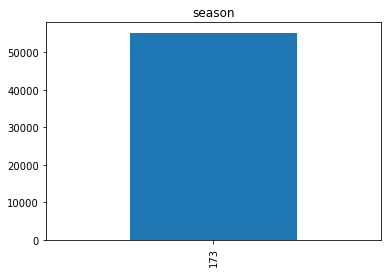



COLUMN: club_id
Number of unique values: 55314


COLUMN: league_id
Number of unique values: 3951


COLUMN: dynamic_payment_segment
0) NonPayer    41843
2) Minnow       6047
1) ExPayer      5025
3) Dolphin      1854
4) Whale         545
Name: dynamic_payment_segment, dtype: int64


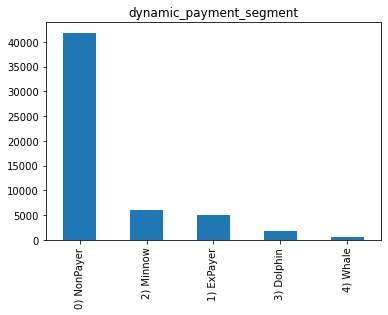



COLUMN: cohort_season
Min: 1
Max: 172
Mean: 23.409371949235275
Median: 4.0


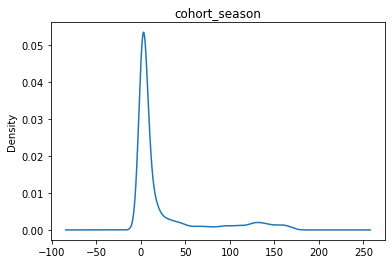



COLUMN: avg_age_top_11_players
Min: 18
Max: 33
Mean: 23.718660736883972
Median: 23.0


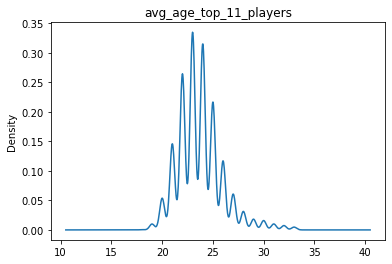



COLUMN: avg_stars_top_11_players
Min: 1.45169697154652
Max: 23.716072813091856
Mean: 4.533515704240132
Median: 4.481375760165127


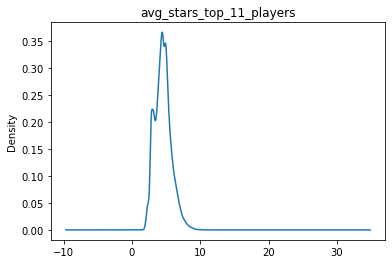



COLUMN: avg_stars_top_14_players
Min: 1.35490476335798
Max: 20.43487618582589
Mean: 4.344775636354571
Median: 4.31159047081357


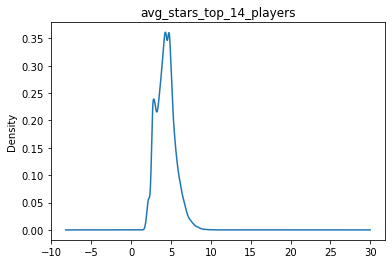



COLUMN: avg_training_factor_top_11_players
Min: -1.287736496867163
Max: 5.164494312463842
Mean: 0.5843718184944816
Median: 0.5611579609248674


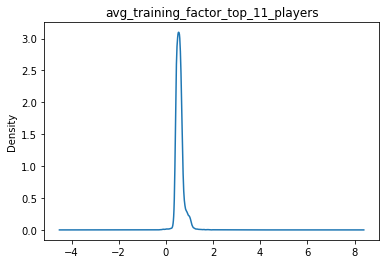



COLUMN: days_active_last_28_days
Min: 0
Max: 28
Mean: 12.357088621325524
Median: 7.0


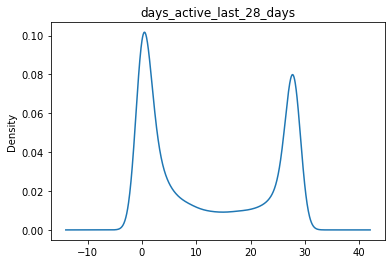



COLUMN: league_match_watched_count_last_28_days
Min: 0
Max: 26
Mean: 3.6231695411649856
Median: 0.0


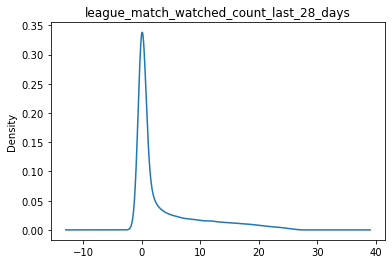



COLUMN: session_count_last_28_days
Min: 0
Max: 1365
Mean: 63.43216907112124
Median: 16.0


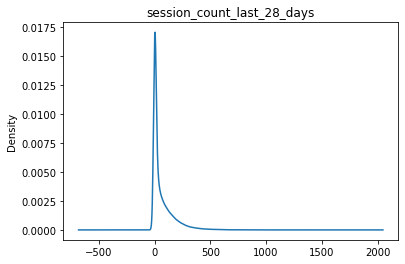



COLUMN: playtime_last_28_days
Min: 0
Max: 1340478682
Mean: 29551777.039646383
Median: 6230431.0


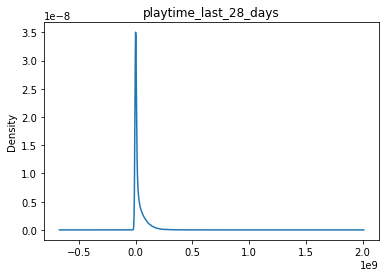



COLUMN: registration_country
Number of unique values: 186


COLUMN: registration_platform_specific
Android Phone               35859
iOS Phone                    9896
Flash FB Canvas              4340
Android Tablet               1867
iOS Tablet                   1214
UniversalWindows PC           724
WebGL FB Canvas               702
WebGL TE Site                 489
WebGL or Flash FB Canvas      129
Flash TE Site                  77
WebGL or Flash TE Site         17
Name: registration_platform_specific, dtype: int64


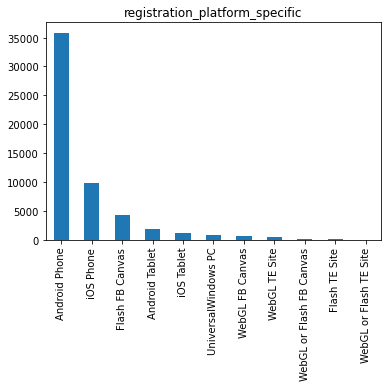



COLUMN: league_match_won_count_last_28_days
Min: 0
Max: 26
Mean: 12.411812561015294
Median: 12.0


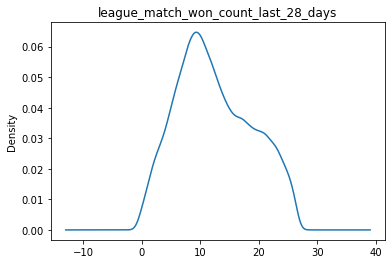



COLUMN: training_count_last_28_days
Min: 0
Max: 7443
Mean: 61.10769425461908
Median: 11.0


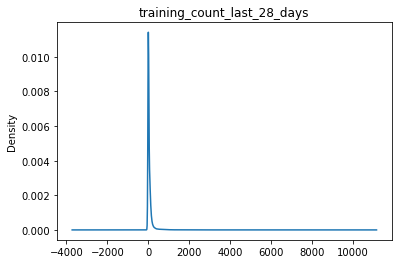



COLUMN: global_competition_level
1.0     10389
2.0      4898
3.0      3965
5.0      3701
6.0      3651
7.0      3458
4.0      3409
8.0      2374
9.0      1327
10.0      455
11.0      136
Name: global_competition_level, dtype: int64


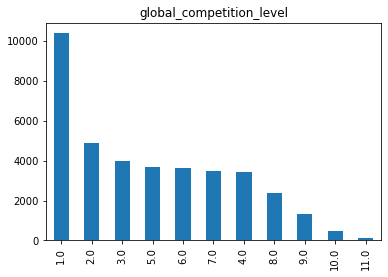



COLUMN: tokens_spent_last_28_days
Min: 0
Max: 120233
Mean: 121.39389666268937
Median: 38.0


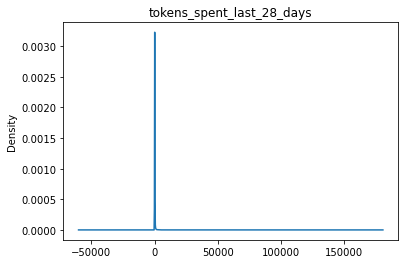



COLUMN: tokens_stash
Min: -4975
Max: 744202
Mean: 113.13307661713128
Median: 29.0


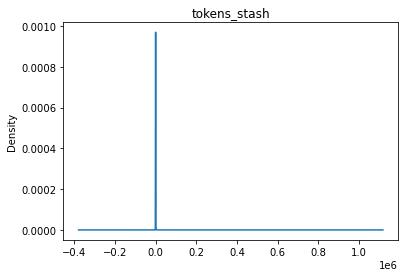



COLUMN: rests_stash
Min: -169
Max: 32767
Mean: 283.083523158694
Median: 88.0


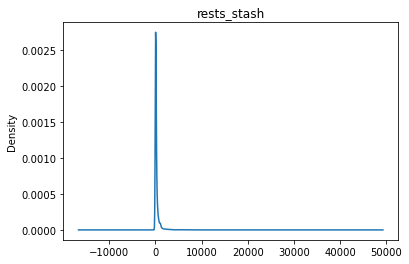



COLUMN: morale_boosters_stash
Min: 0
Max: 32767
Mean: 307.085963770474
Median: 118.0


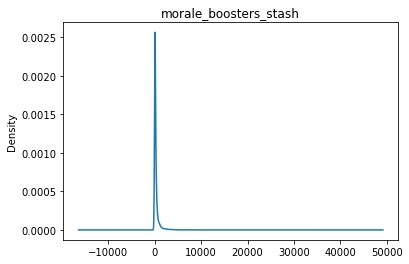



COLUMN: league_rank
2     3951
1     3951
6     3951
10    3951
12    3951
7     3951
5     3951
8     3951
3     3951
4     3951
11    3951
14    3951
9     3951
13    3951
Name: league_rank, dtype: int64


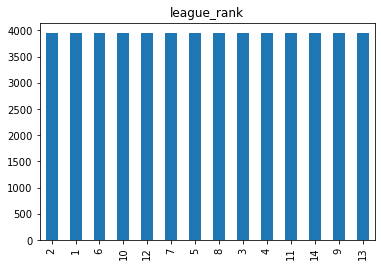



|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


def exploratory_data_analysis(df):
    print('Number of Missing values')
    print(df.isnull().sum())
    print('\n')

    for i in df.columns:
        print('COLUMN: {}'.format(i))
        if ('id' in i) | ('country' in i):
            print('Number of unique values: {}'.format(df[i].nunique()))
        else:
            if df[i].nunique() < 15:
                print(df[i].value_counts())
                df[i].value_counts().plot(kind='bar')
                plt.title(i)
                plt.show()
            else:
                if df[i].dtype.kind in 'bifc':
                    print('Min: {}'.format(df[i].min()))
                    print('Max: {}'.format(df[i].max()))
                    print('Mean: {}'.format(df[i].mean()))
                    print('Median: {}'.format(df[i].median()))
                    df[i].plot(kind='kde')
                    plt.title(i)
                    plt.show()
        print('\n')


def preprocess_data(df2):
    df2 = df2.drop(['season', 'club_id', 'league_id'], axis=1)
    df2['dynamic_payment_segment2'] = df2['dynamic_payment_segment'].str[2:]

    dm = pd.get_dummies(df2['dynamic_payment_segment2'])
    df2 = pd.concat([df2, dm], axis=1)
    df2 = df2.drop(['dynamic_payment_segment', 'dynamic_payment_segment2'], axis=1)
    df2 = df2.drop('registration_platform_specific', axis=1)
    df2['registration_country_cd'] = pd.Categorical(df2['registration_country'],
                                                    categories=df2['registration_country'].unique()).codes
    df2 = df2.drop('registration_country', axis=1)
    df2['global_competition_level'].fillna(0, inplace=True)

    return df2


def create_features_and_target(df2):
    X = df2.copy().drop('league_rank', axis=1)
    Y = df2['league_rank']

    return X, Y


def split(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
    return X_train, X_test, Y_train, Y_test


def scale(X_train, X_test):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    return X_train, X_test


def xgboost_hyper_param(learning_rate, n_estimators, max_depth, gamma):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)

    clf = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        gamma=gamma,
        n_jobs=-1
    )

    return np.mean(cross_val_score(clf, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error'))


def optimize_hyperparameters(X_train, Y_train):
    pbounds = {
        'learning_rate': (0.01, 1.0),
        'n_estimators': (100, 1000),
        'max_depth': (5, 20),
        'gamma': (2, 8)
    }

    optimizer = BayesianOptimization(
        f=xgboost_hyper_param,
        pbounds=pbounds,
        random_state=1)

    optimizer.maximize(init_points=10, n_iter=5)

    best_params = optimizer.max['params']

    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['n_estimators'] = int(best_params['n_estimators'])

    model = XGBRegressor(
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        gamma=best_params['gamma'],
        n_jobs=-1
    )

    model.fit(X_train, Y_train)

    return model, best_params


def evaluate_model(model, X_test, Y_test):
    err = mae(Y_test, model.predict(X_test))
    print('MAE: {}'.format(err))

    aa = model.predict(X_test)
    aa2 = [14 if i >= 14 else 1 if i <= 1 else round(i) for i in aa]

    err2 = mae(Y_test, aa2)
    print('MAE Round: {}'.format(err2))


def plot_fimportance(model, X):
    n_features = X.shape[1]
    plt.figure(figsize=(20, 20))
    plt.barh(range(n_features), model.feature_importances_)
    plt.yticks(np.arange(n_features), X.columns.values)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


def make_predictions(df_test, df2, best_params):
    df_test2 = preprocess_data(df_test)
    X, Y = create_features_and_target(df2)

    X_scaled, df5 = scale(X, df_test2)

    model2 = XGBRegressor(**best_params, n_jobs=-1, random_state=1)
    model2.fit(X_scaled, Y)

    plot_fimportance(model2, X)

    pp = model2.predict(df5)
    pp2 = [14 if i >= 14 else 1 if i <= 1 else round(i) for i in pp]

    df_test['league_rank'] = pp2
    df_test3 = df_test[['club_id', 'league_rank']].copy()

    return df_test3


df = pd.read_csv('jobfair_train.csv')
exploratory_data_analysis(df)
df2 = preprocess_data(df)

X, Y = create_features_and_target(df2)
X_train, X_test, Y_train, Y_test = split(X, Y)
X_train, X_test = scale(X_train, X_test)

model, best_params = optimize_hyperparameters(X_train, Y_train)
evaluate_model(model, X_test, Y_test)
plot_fimportance(model, X)

df_test = pd.read_csv('jobfair_test.csv')
predictions = make_predictions(df_test, df2, best_params)
predictions.to_csv('Nordeus_Challenge_predictions.csv', index=False)
